In [1]:
# filter some warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
os.chdir('/glade/u/home/shunzlu/work/Projects/SubpolarGyres')

In [3]:
import xesmf as xe
import xarray as xr
import numpy as np

from scipy import signal
from xgcm import Grid

import matplotlib.pyplot as plt


In [4]:
import gsw

In [5]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [6]:
from myfunctions import ReadDataFromNCAR, select_month, openpickle, connect_dask_cluster

In [9]:
ds_sf = ReadDataFromNCAR(variable_id = ['msftyz'], grid_label = 'gn', table_id="Omon")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [11]:
sf = ds_sf.msftyz.isel(basin = 2)

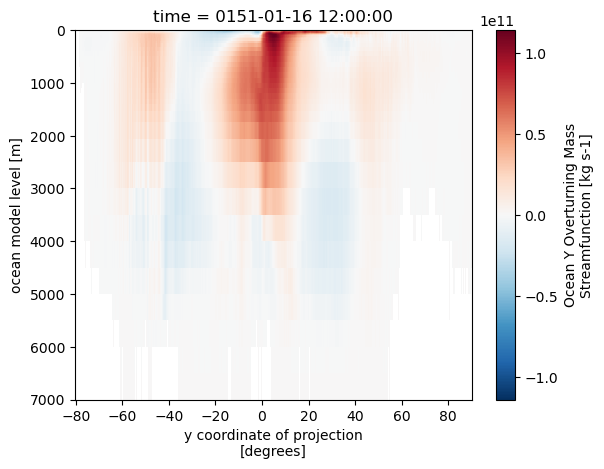

In [14]:
sf.isel(time=0).plot()
plt.gca().invert_yaxis()

In [15]:
ds_s = ReadDataFromNCAR(variable_id = ['so'], grid_label = 'gn', table_id="Omon")
ds_t = ReadDataFromNCAR(variable_id = ['thetao'], grid_label = 'gn', table_id="Omon")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [7]:
ds_basin = ReadDataFromNCAR(variable_id = 'basin', grid_label = 'gn')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [8]:
sf = ds_sf.msftyz.isel(basin = 0)

In [17]:
da_s_at = ds_s.so.where(ds_basin.basin == 2)
da_t_at = ds_t.thetao.where(ds_basin.basin == 2)

In [18]:
da_s_34 = da_s_at.sel(y=-34, method='nearest')
da_t_34 = da_t_at.sel(y=-34, method='nearest')

In [21]:
sigma2_34 = gsw.sigma2(da_s_34, da_t_34)

In [22]:
sigma2_34_at = sigma2_34.mean('x')
sigma2_34_at_ann = sigma2_34_at.groupby('time.year').mean('time')

In [9]:
client, cluster = connect_dask_cluster()
print(f"Dask Dashboard link: {client.dashboard_link}")

Dask Dashboard link: https://jupyterhub.hpc.ucar.edu/stable/user/shunzlu/proxy/39169/status


2025-12-10 11:52:28,381 - bokeh.server.protocol_handler - ERROR - error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p84165'}, 'attr': 'end', 'new': 70265.29607609654}]} 
 error: AssertionError()
Traceback (most recent call last):
  File "/glade/work/shunzlu/conda-envs/my-env/lib/python3.11/site-packages/bokeh/server/protocol_handler.py", line 97, in handle
    work = await handler(message, connection)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/glade/work/shunzlu/conda-envs/my-env/lib/python3.11/site-packages/bokeh/server/session.py", line 295, in patch
    return connection.session._handle_patch(message, connection)
           ^^^^^^^^^^^^^^^^^^
  File "/glade/work/shunzlu/conda-envs/my-env/lib/python3.11/site-packages/bokeh/server/connection.py", line 65, in session
    assert self._session is not None
           ^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError
2025-12-10 11:52:28,598 - bokeh.server.protocol_handler

In [10]:
sf_34_ann = sf.sel(y = -34, method = 'nearest').groupby("time.year").mean("time").compute()

Text(0.5, 1.0, 'Annual streamfunction at 34S')

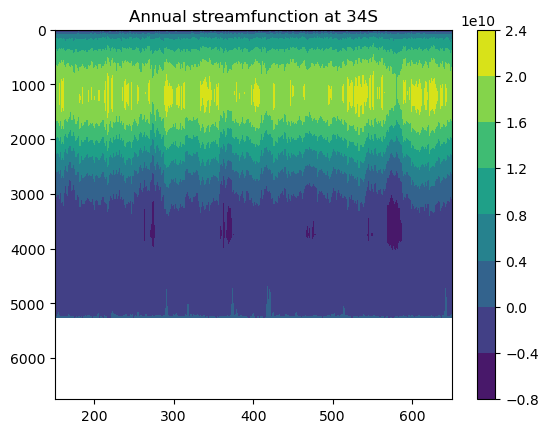

In [60]:
plt.contourf(sf_34_ann.year, sf_34_ann.lev, sf_34_ann.transpose())
plt.gca().invert_yaxis()
plt.colorbar()
plt.title('Annual streamfunction at 34S')

In [61]:
def calculate_psi_depth(sf, levname='lev', lev_slice = (1500, 6000)):
    if isinstance(lev_slice, tuple):
        sfb = sf.sel({levname: slice(lev_slice[0], lev_slice[1])})
        sff = sf.sel({levname: slice(0, lev_slice[0])})
    depth_max = sf[levname][sf.argmax(levname)]
    depth_min = sfb[levname][sfb.argmin(levname)]
    sfnew = sf.where(sf[levname]>=depth_max).where(sf[levname]<=depth_min)
    lev1 = sfnew[levname][sfnew.where(sfnew>0).argmin(levname)]
    lev2 = sfnew[levname][sfnew.where(sfnew>0).argmin(levname)+1]
    sf1 = sfnew.sel({levname: lev1})
    sf2 = sfnew.sel({levname: lev2})
    dep = sf1/(sf1-sf2)*(lev2-lev1) + lev1
    return depth_max, depth_min, dep

In [62]:
depth_34_max, depth_34_min, depth_34_zero = calculate_psi_depth(sf_34_ann)

In [63]:
depth_34_min = depth_34_min.reset_coords(names="lev", drop=True)

In [64]:
sigma2_AABW_ann = sigma2_34_at_ann.sel(lev = depth_34_min, method = 'nearest')

In [65]:
sigma2_AABW_ann = sigma2_AABW_ann.compute()

In [66]:
sigma2_AABW_ann.mean()

<xarray.DataArray 'so' ()> Size: 8B
array(36.929973)
Coordinates:
    y        float64 8B -34.05

In [35]:
sigma2 = gsw.sigma2(ds_s.so, ds_t.thetao)

In [36]:
sigma2_ws_west = sigma2.sel(y = slice(-90, -30)).sel(x = slice(-60, -30))
sigma2_ws_all = sigma2.sel(y = slice(-90, -30)).sel(x = slice(-60, 60))

In [37]:
sigma2_ws_west_ann = sigma2_ws_west.groupby('time.year').mean('time')
sigma2_ws_all_ann = sigma2_ws_all.groupby('time.year').mean('time')

In [43]:
sigma2_ws_west_transect_mean = sigma2_ws_west_ann.mean('x').mean('year').compute()

Text(0.5, 1.0, 'Sigma2 Transect Mean (60W-30W Sector)')

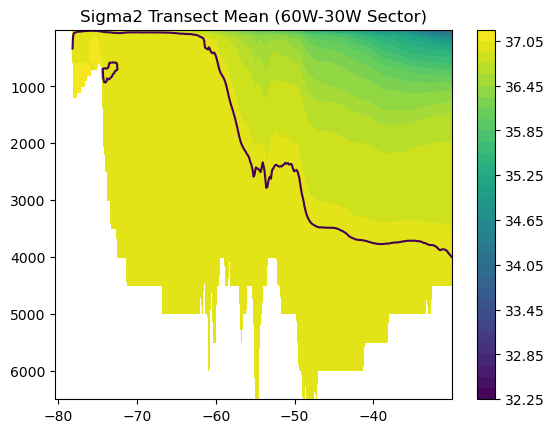

In [67]:
plt.contourf(sigma2_ws_west_transect_mean.y, sigma2_ws_west_transect_mean.lev, sigma2_ws_west_transect_mean, levels = 40)
plt.colorbar()
plt.contour(sigma2_ws_west_transect_mean.y, sigma2_ws_west_transect_mean.lev, sigma2_ws_west_transect_mean, levels = [sigma2_AABW_ann.mean().item()])
plt.gca().invert_yaxis()
plt.title('Sigma2 Transect Mean (60W-30W Sector)')

In [72]:
sigma2_map = sigma2_ws_all_ann.where(sigma2_ws_all_ann > sigma2_AABW_ann.mean().item()).mean('lev').mean('year').compute()

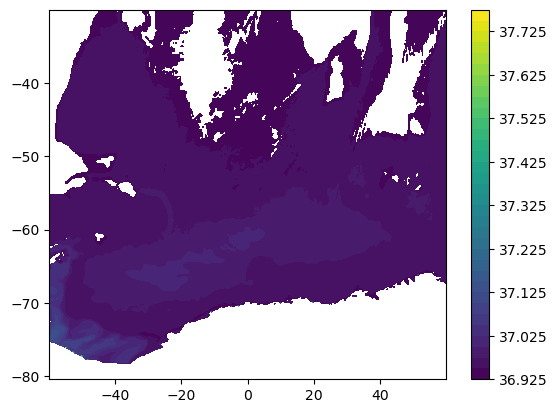

In [74]:
plt.contourf(sigma2_map.x, sigma2_map.y, sigma2_map, levels = 40)
plt.colorbar()

In [75]:
ds_fx = ReadDataFromNCAR(variable_id = ["volcello"], grid_label = "gn")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [76]:
sigma2_weddell = sigma2.sel(y = slice(-90, -70), x = slice(-60, 0)).groupby('time.year').mean('time')
sigma2_weddell_o = sigma2.sel(y = slice(-90, -60), x = slice(-60, 0)).groupby('time.year').mean('time')

In [77]:
AABW_weddell = ds_fx.volcello.where(sigma2_weddell >= sigma2_AABW_ann.mean().item()).sum(('x','y','lev')) / 1e9 # m3 to km3
AABW_weddell_o = ds_fx.volcello.where(sigma2_weddell_o >= sigma2_AABW_ann.mean().item()).sum(('x','y','lev')) / 1e9

: 

: 

: 

In [ ]:
AABW_weddell

In [7]:
heat_trans_v_AL_sep_34 = openpickle('heat_trans_v_AL_sep_34', 'data/')
salt_trans_v_AL_sep_34 = openpickle('salt_trans_v_AL_sep_34', 'data/')

Text(0, 0.5, 'Depth (m)')

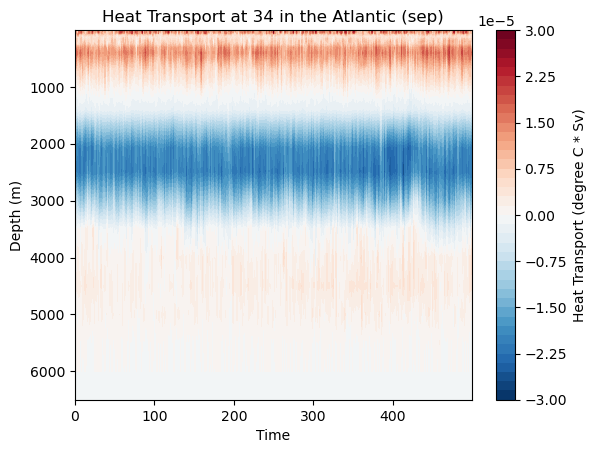

In [35]:
plt.contourf(range(len(heat_trans_v_AL_sep_34.time)), heat_trans_v_AL_sep_34.lev, 
             heat_trans_v_AL_sep_34.transpose(), vmin = -3e-5, vmax = 3e-5, levels = 50, cmap='RdBu_r')
plt.colorbar(label='Heat Transport (degree C * Sv)')
plt.title("Heat Transport at 34 in the Atlantic (sep)")
plt.gca().invert_yaxis()
plt.xlabel("Time")
plt.ylabel("Depth (m)")

In [7]:
def compute_AABW_transport(trans):
    AABW_tran = []
    for t in trans.time:
        heat_t = trans.sel(time=t)
        int = heat_t.argmin('lev').item()
        heat_t2 = heat_t.isel(lev = slice(int, None))
        heat_AABW_0 = heat_t2.where(heat_t2 > 0).sum('lev')
        AABW_tran.append(heat_AABW_0)
    return xr.concat(AABW_tran, dim='time')

In [15]:
def compute_NADW_transport(trans):
    NADW_tran = []
    for t in trans.time:
        heat_t = trans.sel(time=t)
        heat_NADW_0 = heat_t.where(heat_t < 0).sum('lev')
        NADW_tran.append(heat_NADW_0)
    return xr.concat(NADW_tran, dim='time')

Text(0.5, 1.0, 'NADW Heat Transport at 34S in the Atlantic (sep)')

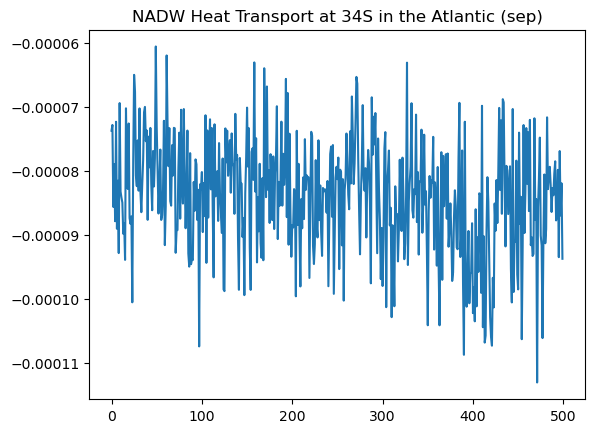

In [16]:
plt.plot(compute_NADW_transport(heat_trans_v_AL_sep_34))
plt.title("NADW Heat Transport at 34S in the Atlantic (sep)")

Text(0.5, 1.0, 'NADW Salt Transport at 34S in the Atlantic (sep)')

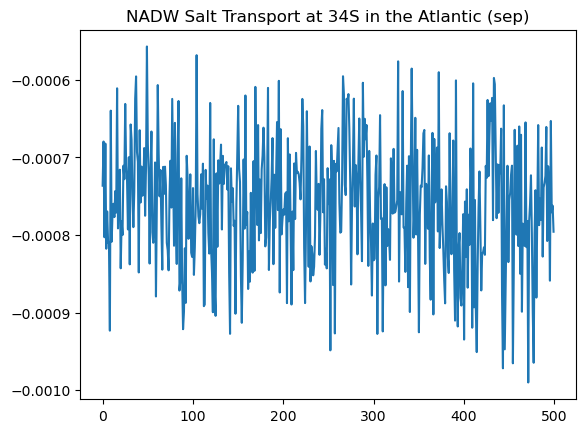

In [17]:
plt.plot(compute_NADW_transport(salt_trans_v_AL_sep_34))
plt.title("NADW Salt Transport at 34S in the Atlantic (sep)")

Text(0.5, 1.0, 'AABW Heat Transport at 34S in the Atlantic (sep)')

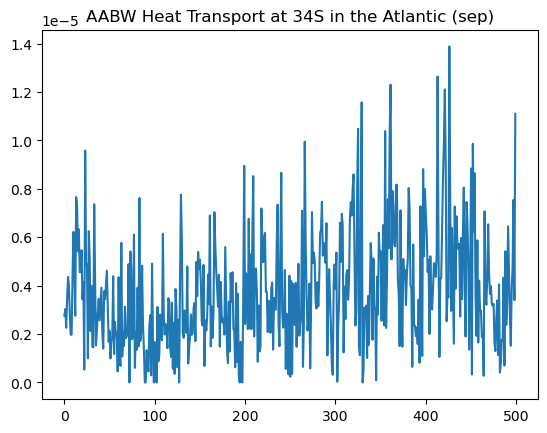

In [54]:
plt.plot(compute_AABW_transport(heat_trans_v_AL_sep_34))
plt.title("AABW Heat Transport at 34S in the Atlantic (sep)")

Text(0.5, 1.0, 'AABW Salt Transport at 34S in the Atlantic (sep)')

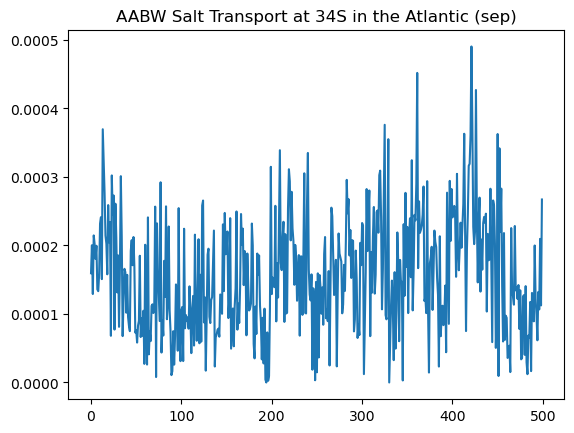

In [55]:
plt.plot(compute_AABW_transport(salt_trans_v_AL_sep_34))
plt.title("AABW Salt Transport at 34S in the Atlantic (sep)")

Text(0, 0.5, 'Depth (m)')

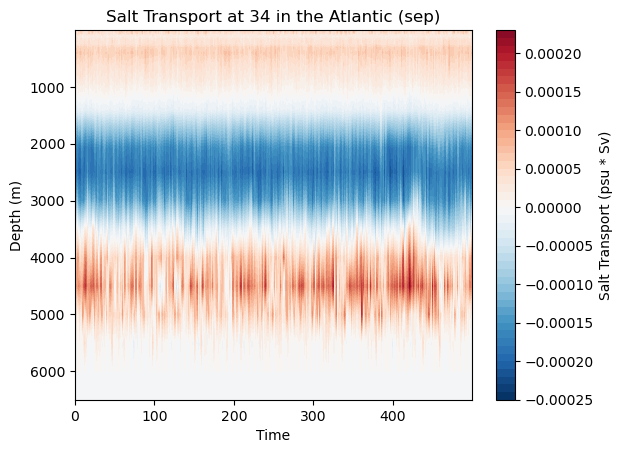

In [38]:
plt.contourf(range(len(salt_trans_v_AL_sep_34.time)), salt_trans_v_AL_sep_34.lev, 
             salt_trans_v_AL_sep_34.transpose(),
             vmin = -0.00025, vmax = 0.00025,  
             levels = 50, cmap='RdBu_r')
plt.colorbar(label='Salt Transport (psu * Sv)')
plt.title("Salt Transport at 34 in the Atlantic (sep)")
plt.gca().invert_yaxis()
plt.xlabel("Time")
plt.ylabel("Depth (m)")

In [8]:
AMOC_34S = openpickle('AMOC_34S', 'data/')

In [15]:
select_month(AMOC_34S.rho_low_time, 9)

<xarray.DataArray 'rho_low_time' (time: 500)> Size: 4kB
array([1036.5625, 1036.4375, 1036.5625, 1036.5625, 1036.4375, 1036.4375,
       1036.5625, 1036.5625, 1036.5625, 1036.5625, 1036.5625, 1036.4375,
       1036.5625, 1036.4375, 1036.5625, 1036.5625, 1036.5625, 1036.5625,
       1036.4375, 1036.5625, 1036.4375, 1036.5625, 1036.5625, 1036.5625,
       1036.4375, 1036.4375, 1036.5625, 1036.5625, 1036.5625, 1036.5625,
       1036.3125, 1036.5625, 1036.5625, 1036.5625, 1036.5625, 1036.5625,
       1036.5625, 1036.5625, 1036.4375, 1036.5625, 1036.5625, 1036.5625,
       1036.5625, 1036.5625, 1036.5625, 1036.5625, 1036.5625, 1036.4375,
       1036.5625, 1036.6875, 1036.5625, 1036.5625, 1036.5625, 1036.5625,
       1036.5625, 1036.5625, 1036.5625, 1036.5625, 1036.4375, 1036.5625,
       1036.5625, 1036.5625, 1036.5625, 1036.4375, 1036.5625, 1036.5625,
       1036.5625, 1036.5625, 1036.5625, 1036.5625, 1036.5625, 1036.5625,
       1036.5625, 1036.5625, 1036.4375, 1036.5625, 1036.5625, 1036.5625,
       1036.5625, 1036.5625, 1036.5625, 1036.4375, 1036.4375, 1036.5625,
       1036.5625, 1036.5625, 1036.5625, 1036.5625, 1036.5625, 1036.5625,
       1036.5625, 1036.5625, 1036.5625, 1036.5625, 1036.5625, 1036.4375,
       1036.5625, 1036.5625, 1036.5625, 1036.4375, 1036.5625, 1036.5625,
       1036.5625, 1036.5625, 1036.5625, 1036.5625, 1036.1875, 1036.5625,
       1036.5625, 1036.5625, 1036.5625, 1036.5625, 1036.5625, 1036.5625,
       1036.5625, 1036.5625, 1036.5625, 1036.5625, 1036.4375, 1036.5625,
...
       1036.5625, 1036.5625, 1036.5625, 1036.5625, 1036.5625, 1036.5625,
       1036.4375, 1036.4375, 1036.4375, 1036.5625, 1036.4375, 1036.5625,
       1036.5625, 1036.3125, 1036.4375, 1036.5625, 1036.4375, 1036.4375,
       1036.4375, 1036.5625, 1036.5625, 1036.5625, 1036.5625, 1036.4375,
       1036.4375, 1036.4375, 1036.4375, 1036.4375, 1036.5625, 1036.4375,
       1036.5625, 1036.5625, 1036.5625, 1036.3125, 1036.1875, 1036.4375,
       1036.4375, 1036.3125, 1036.3125, 1036.5625, 1036.5625, 1036.5625,
       1036.4375, 1036.4375, 1036.4375, 1036.3125, 1036.1875, 1036.3125,
       1036.4375, 1036.5625, 1036.4375, 1036.4375, 1036.3125, 1036.5625,
       1036.5625, 1036.3125, 1036.5625, 1036.5625, 1036.5625, 1036.5625,
       1036.5625, 1036.5625, 1036.5625, 1036.4375, 1036.5625, 1036.5625,
       1036.1875, 1036.5625, 1036.5625, 1036.5625, 1036.5625, 1036.5625,
       1036.5625, 1036.5625, 1036.5625, 1036.5625, 1036.5625, 1036.5625,
       1036.5625, 1036.5625, 1036.5625, 1036.5625, 1036.5625, 1036.5625,
       1036.5625, 1036.5625, 1036.5625, 1036.5625, 1036.5625, 1036.5625,
       1036.4375, 1036.5625, 1036.5625, 1036.5625, 1036.5625, 1036.5625,
       1036.5625, 1036.5625, 1036.5625, 1036.5625, 1036.5625, 1036.4375,
       1036.5625, 1036.4375, 1036.5625, 1036.4375, 1036.5625, 1036.5625,
       1036.5625, 1036.5625, 1036.3125, 1036.5625, 1036.5625, 1036.5625,
       1036.5625, 1036.4375])
Coordinates:
  * time          (time) object 4kB 0151-09-16 00:00:00 ... 0650-09-16 00:00:00
    y             float64 8B -34.05
    rho_up_time   (time) float64 4kB 1.037e+03 1.036e+03 ... 1.037e+03 1.036e+03
    rho_low_time  (time) float64 4kB 1.037e+03 1.036e+03 ... 1.037e+03 1.036e+03

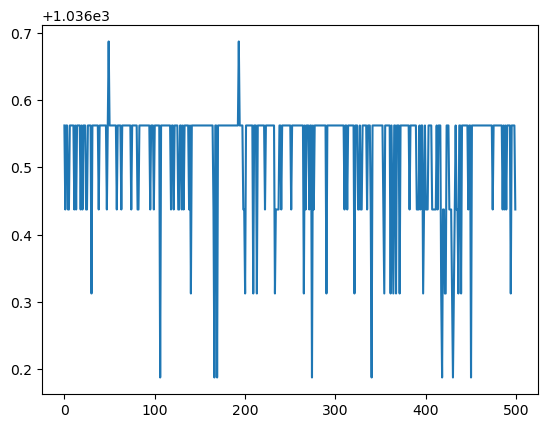

In [43]:
plt.plot(select_month(AMOC_34S.rho_low_time, 9))

In [9]:
AABW_r_psi = openpickle("AABW_r_psi", "data/")
AABW_w_psi = openpickle("AABW_w_psi", "data/")

AABW_ross_sep = openpickle("AABW_ross_sep", "data/")
AABW_ross_o_sep = openpickle("AABW_ross_o_sep", "data/")

AABW_weddell_sep = openpickle("AABW_weddell_sep", "data/")
AABW_weddell_o_sep = openpickle("AABW_weddell_o_sep", "data/")

AABW_sv_rho_sep = openpickle("AABW_sv_rho_sep", "data/")                       

Text(0.5, 1.0, '70S-90S Weddell AABW volume Sep (km^3)')

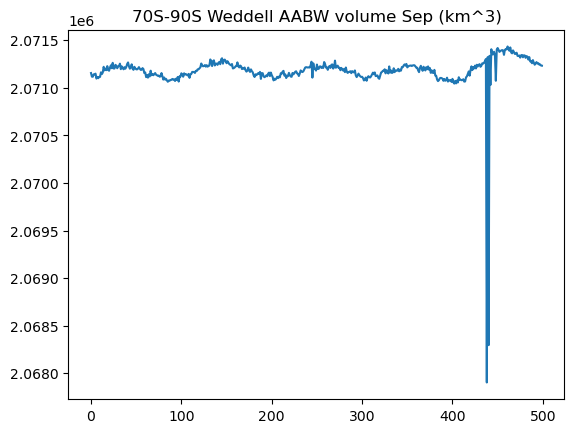

In [13]:
plt.plot(AABW_weddell_sep)
plt.title("70S-90S Weddell AABW volume Sep (km^3)")

Text(0.5, 1.0, '60S-90S Weddell AABW volume Sep (km^3)')

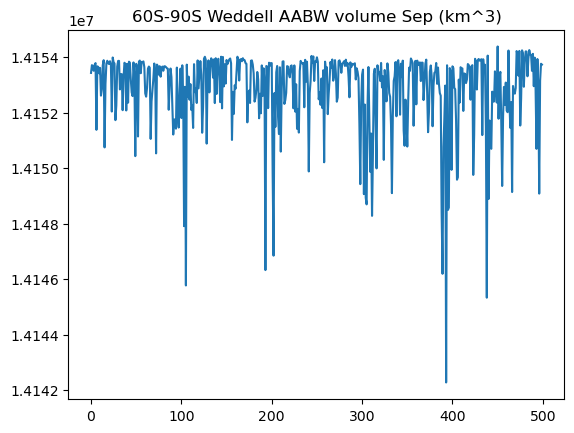

In [12]:
plt.plot(AABW_weddell_o_sep)
plt.title("60S-90S Weddell AABW volume Sep (km^3)")

Text(0.5, 1.0, '60S-70S Weddell AABW volume Sep (km^3) [Difference]')

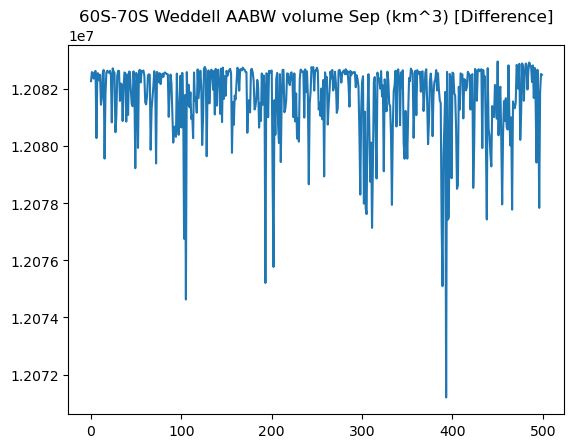

In [15]:
plt.plot(AABW_weddell_o_sep - AABW_weddell_sep)
plt.title("60S-70S Weddell AABW volume Sep (km^3) [Difference]")

Text(0.5, 1.0, '70S-90S Ross AABW volume Sep (km^3)')

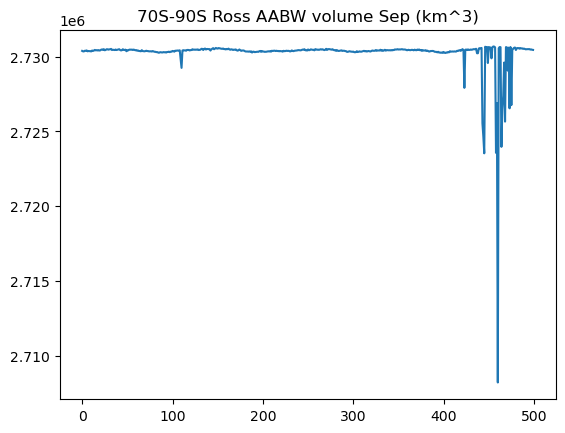

In [17]:
plt.plot(AABW_ross_sep)
plt.title("70S-90S Ross AABW volume Sep (km^3)")

Text(0.5, 1.0, '60S-90S Ross AABW volume Sep (km^3)')

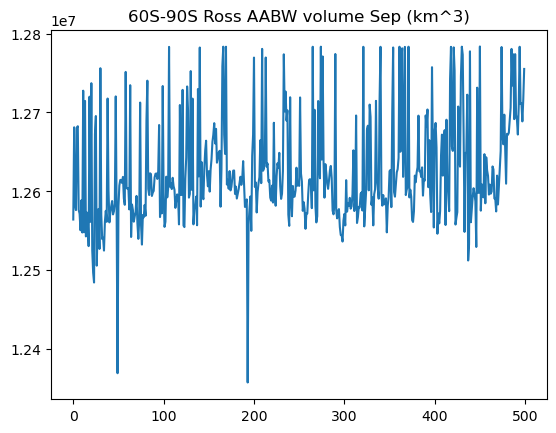

In [18]:
plt.plot(AABW_ross_o_sep)
plt.title("60S-90S Ross AABW volume Sep (km^3)")

Text(0.5, 1.0, '60S-70S Ross AABW volume Sep (km^3) [Difference]')

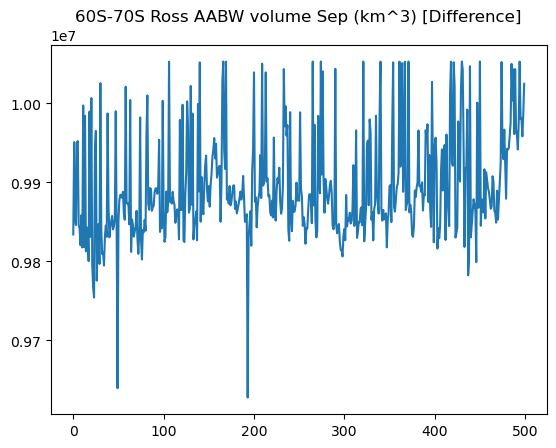

In [19]:
plt.plot(AABW_ross_o_sep - AABW_ross_sep)
plt.title("60S-70S Ross AABW volume Sep (km^3) [Difference]")

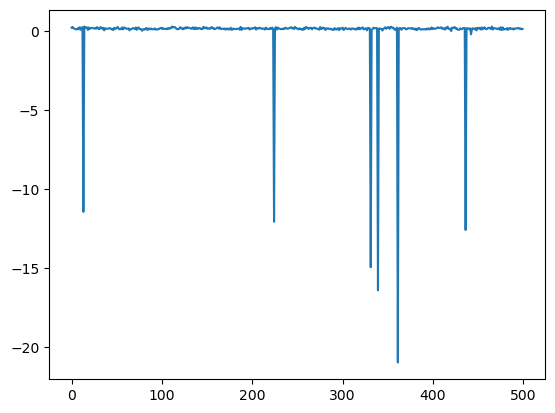

In [18]:
plt.plot(AABW_sv_rho_sep)

In [10]:
ACC_drake_69_sep = openpickle('ACC_drake_69_sep', 'data/')

In [11]:
wind_50_sep = openpickle('wind_50_sep', 'data/')
wind_65_sep = openpickle('wind_65_sep', 'data/')
wind_40_60_sep = openpickle('wind_40_60_sep', 'data/')

In [12]:
Psi_gyres_sep = openpickle('Psi_gyres_sep', 'data/')

In [13]:
from scipy import stats

In [14]:
def lag_cor(x,y,lag, c, l):
    stat=[]
    x = x
    y = y
    from scipy import stats
    for i in range(2*lag):
        slope, intercept, r_value, p_value, std_err = stats.linregress(x[lag:len(x)-lag], y[i:len(y)-2*lag+i])
        stat.append(r_value)
    x=np.linspace(-lag,lag+1, 2*lag)
    plt.grid(True,which="both",ls="-", color='0.65')
    plt.plot(x, stat, c, label=l, linewidth=3.0)
    plt.xlabel('Year lag')
    plt.ylabel('r')

Text(0.5, 1.0, 'Lag correlation between wind stress at 65S and Subpolar Gyre strength')

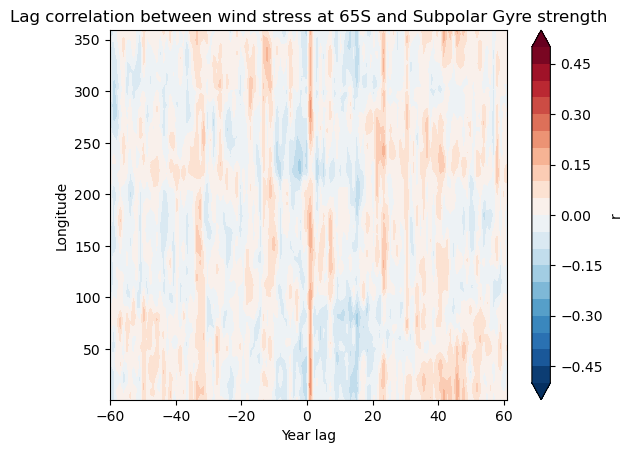

In [ ]:
stat=[]
lag = 60
for l in wind_65_sep.lon:
    y = wind_65_sep.uas.sel(lon=l).values
    x = Psi_gyres_sep.ws.values
    r_values=[]
    for i in range(2*lag):
        slope, intercept, r_value, p_value, std_err = stats.linregress(x[lag:len(x)-lag], y[i:len(y)-2*lag+i])
        r_values.append(r_value)
    stat.extend(r_values)


plt.contourf(np.linspace(-lag,lag+1, 2*lag), wind_65_sep.lon, np.array(stat).reshape(len(wind_65_sep.lon), 2*lag), levels=np.linspace(-0.5,0.5,21), cmap='RdBu_r', extend='both')
plt.colorbar(label='r')
plt.xlabel('Year lag')
plt.ylabel('Longitude')
plt.title('Lag correlation between zonal wind speed at 65S and Weddell Gyre strength')

In [15]:
Psi_gyres_sep = openpickle('Psi_gyres_sep', 'data/')
Psi_SO_avg = openpickle('Psi_SO_avg', 'data/')

conv_rs = openpickle('conv_rs', 'data/')
conv_ws = openpickle('conv_ws', 'data/')

In [16]:
gyre_ws = Psi_SO_avg.sep.sel(x=slice(-60, 60))
gyre_rs = Psi_SO_avg.sep.sel(x=slice(-220, -120))

In [18]:
wsbox = conv_ws.where(conv_ws > 0, drop = True).x.min().item(), conv_ws.where(conv_ws > 0, drop = True).x.max().item(), conv_ws.where(conv_ws > 0, drop = True).y.min().item(), conv_ws.where(conv_ws > 0, drop = True).y.max().item()
rsbox = conv_rs.where(conv_rs > 0, drop = True).x.min().item(), conv_rs.where(conv_rs > 0, drop = True).x.max().item(), conv_rs.where(conv_rs > 0, drop = True).y.min().item(), conv_rs.where(conv_rs > 0, drop = True).y.max().item()

In [19]:
def butterfilter(data, cutoff: float, sample_rate: float=1, poles: int = 4, btype: str = 'lowpass'):
    sos = signal.butter(poles, cutoff, btype=btype, output='sos', fs=sample_rate)
    return signal.sosfiltfilt(sos, data)

In [20]:
def running_mean(data, window_size: int=10):
    kernel = np.ones(window_size) / window_size
    return np.convolve(data, kernel, mode='same')

In [21]:
def subplot_filter(data, ax, name):
    ax.plot(data, label='original', alpha = 0.5, c = 'C0', linewidth=0.8)
    # ax.plot(running_mean(data), label='10-yr running mean', c = 'C2', linewidth=1)
    # ax.plot(butterfilter(data, [1/70, 1/10], btype='bandstop'), label='10 ~ 70yrs', alpha=0.6, c = 'C1', linewidth=1)
    ax.plot(butterfilter(data, 1/70, btype='lowpass'), label='> 70yrs', c = 'C3', linewidth=1)
    # ax.legend(ncol=4)
    ax.set_ylabel(name)

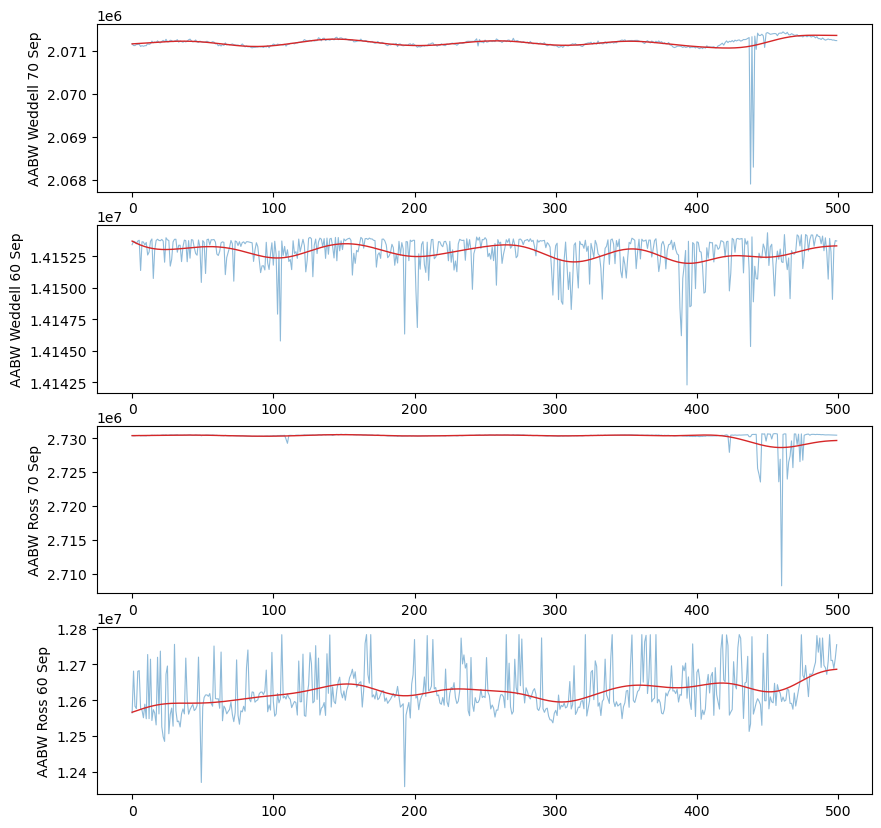

In [73]:
plt.figure(figsize=(10,10))

ax1 = plt.subplot(4,1,1)

subplot_filter(AABW_weddell_sep, ax1, 'AABW Weddell 70 Sep')

ax2 = plt.subplot(4,1,2)
subplot_filter(AABW_weddell_o_sep, ax2, 'AABW Weddell 60 Sep')

ax3 = plt.subplot(4,1,3)
subplot_filter(AABW_ross_sep, ax3, 'AABW Ross 70 Sep')

ax4 = plt.subplot(4,1,4)
subplot_filter(AABW_ross_o_sep, ax4, 'AABW Ross 60 Sep')

In [22]:
def butterfilter_gust(data, cutoff: float, sample_rate: float=1, poles: int = 4, btype: str = 'lowpass'):
    b, a = signal.butter(poles, cutoff, btype=btype, fs=sample_rate)
    return signal.filtfilt(b, a, data, method="gust")

In [23]:
def lowpass_70_gust(data):
    return butterfilter_gust(data, 1/70, btype='lowpass')

In [24]:
ACC_drake_69_sep = openpickle('ACC_drake_69_sep', 'data/')

Text(0.5, 1.0, 'Lag Correlation with ACC at Drake Passage [400 yrs]')

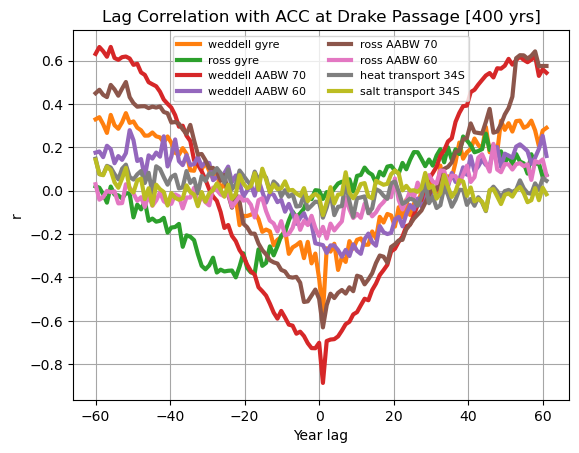

In [26]:
lag_time = 60

fig = plt.figure()
lag_cor(ACC_drake_69_sep.isel(time = slice(0, 400)), -Psi_gyres_sep.ws.isel(time = slice(0, 400)), lag_time, 'C1' ,'weddell gyre')
lag_cor(ACC_drake_69_sep.isel(time = slice(0, 400)), -Psi_gyres_sep.rs.isel(time = slice(0, 400)), lag_time, 'C2' ,'ross gyre')

lag_cor(ACC_drake_69_sep.isel(time = slice(0, 400)), AABW_weddell_sep.isel(time = slice(0, 400)), lag_time, 'C3' ,'weddell AABW 70')
lag_cor(ACC_drake_69_sep.isel(time = slice(0, 400)), AABW_weddell_o_sep.isel(time = slice(0, 400)), lag_time, 'C4' ,'weddell AABW 60')
lag_cor(ACC_drake_69_sep.isel(time = slice(0, 400)), AABW_ross_sep.isel(time = slice(0, 400)), lag_time, 'C5' ,'ross AABW 70')
lag_cor(ACC_drake_69_sep.isel(time = slice(0, 400)), AABW_ross_o_sep.isel(time = slice(0, 400)), lag_time, 'C6' ,'ross AABW 60')

lag_cor(ACC_drake_69_sep.isel(time = slice(0, 400)), compute_AABW_transport(heat_trans_v_AL_sep_34).isel(time = slice(0, 400)), lag_time, 'C7' ,'heat transport 34S')
lag_cor(ACC_drake_69_sep.isel(time = slice(0, 400)), compute_AABW_transport(salt_trans_v_AL_sep_34).isel(time = slice(0, 400)), lag_time, 'C8' ,'salt transport 34S')
plt.legend(ncol = 2, fontsize=8)
plt.title("Lag Correlation with ACC at Drake Passage [400 yrs]")

Text(0.5, 1.0, 'Lag Correlation with ACC at Drake Passage (>70yrs)')

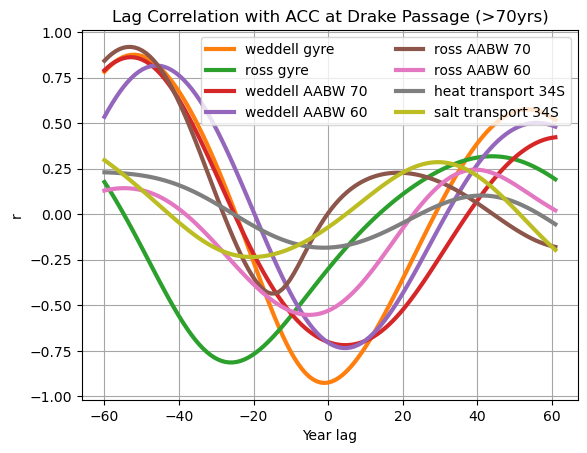

In [81]:
lag_time = 60

fig = plt.figure()
lag_cor(lowpass_70_gust(ACC_drake_69_sep), lowpass_70_gust(-Psi_gyres_sep.ws), lag_time, 'C1' ,'weddell gyre')
lag_cor(lowpass_70_gust(ACC_drake_69_sep), lowpass_70_gust(-Psi_gyres_sep.rs), lag_time, 'C2' ,'ross gyre')

lag_cor(lowpass_70_gust(ACC_drake_69_sep), lowpass_70_gust(AABW_weddell_sep), lag_time, 'C3' ,'weddell AABW 70')
lag_cor(lowpass_70_gust(ACC_drake_69_sep), lowpass_70_gust(AABW_weddell_o_sep), lag_time, 'C4' ,'weddell AABW 60')
lag_cor(lowpass_70_gust(ACC_drake_69_sep), lowpass_70_gust(AABW_ross_sep), lag_time, 'C5' ,'ross AABW 70')
lag_cor(lowpass_70_gust(ACC_drake_69_sep), lowpass_70_gust(AABW_ross_o_sep), lag_time, 'C6' ,'ross AABW 60')

lag_cor(lowpass_70_gust(ACC_drake_69_sep), lowpass_70_gust(compute_AABW_transport(heat_trans_v_AL_sep_34)), lag_time, 'C7' ,'heat transport 34S')
lag_cor(lowpass_70_gust(ACC_drake_69_sep), lowpass_70_gust(compute_AABW_transport(salt_trans_v_AL_sep_34)), lag_time, 'C8' ,'salt transport 34S')

plt.legend(ncol = 2)
plt.title("Lag Correlation with ACC at Drake Passage (>70yrs)")

Text(0.5, 1.0, 'Lag Correlation with ACC at Drake Passage (>70yrs) [First 400 years]')

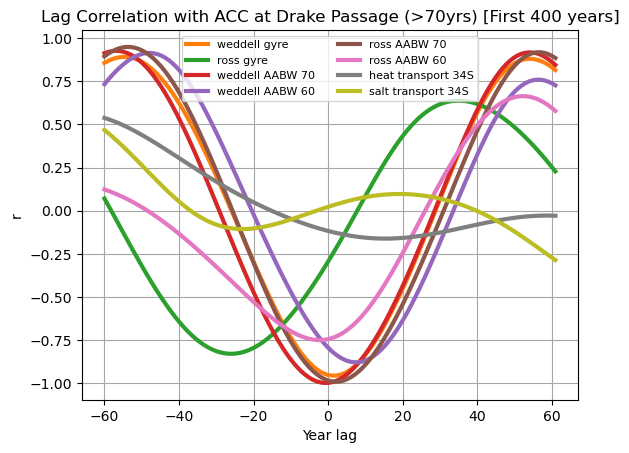

In [86]:
lag_time = 60

fig = plt.figure()
lag_cor(lowpass_70_gust(ACC_drake_69_sep.isel(time = slice(0, 400))), lowpass_70_gust(-Psi_gyres_sep.ws.isel(time = slice(0, 400))), lag_time, 'C1' ,'weddell gyre')
lag_cor(lowpass_70_gust(ACC_drake_69_sep.isel(time = slice(0, 400))), lowpass_70_gust(-Psi_gyres_sep.rs.isel(time = slice(0, 400))), lag_time, 'C2' ,'ross gyre')

lag_cor(lowpass_70_gust(ACC_drake_69_sep.isel(time = slice(0, 400))), lowpass_70_gust(AABW_weddell_sep.isel(time = slice(0, 400))), lag_time, 'C3' ,'weddell AABW 70')
lag_cor(lowpass_70_gust(ACC_drake_69_sep.isel(time = slice(0, 400))), lowpass_70_gust(AABW_weddell_o_sep.isel(time = slice(0, 400))), lag_time, 'C4' ,'weddell AABW 60')
lag_cor(lowpass_70_gust(ACC_drake_69_sep.isel(time = slice(0, 400))), lowpass_70_gust(AABW_ross_sep.isel(time = slice(0, 400))), lag_time, 'C5' ,'ross AABW 70')
lag_cor(lowpass_70_gust(ACC_drake_69_sep.isel(time = slice(0, 400))), lowpass_70_gust(AABW_ross_o_sep.isel(time = slice(0, 400))), lag_time, 'C6' ,'ross AABW 60')

lag_cor(lowpass_70_gust(ACC_drake_69_sep.isel(time = slice(0, 400))), lowpass_70_gust(compute_AABW_transport(heat_trans_v_AL_sep_34).isel(time = slice(0, 400))), lag_time, 'C7' ,'heat transport 34S')
lag_cor(lowpass_70_gust(ACC_drake_69_sep.isel(time = slice(0, 400))), lowpass_70_gust(compute_AABW_transport(salt_trans_v_AL_sep_34).isel(time = slice(0, 400))), lag_time, 'C8' ,'salt transport 34S')
plt.legend(ncol = 2, fontsize=8)
plt.title("Lag Correlation with ACC at Drake Passage (>70yrs) [First 400 years]")

In [59]:
AMO = np.load("data/AMO_new.npy")
SAM = np.load("data/SAM_psl_yearly_GFDL-CM4.npy")
ZW3 = np.load("data/ZW3_500zg_yearly_GFDL-CM4.npy")

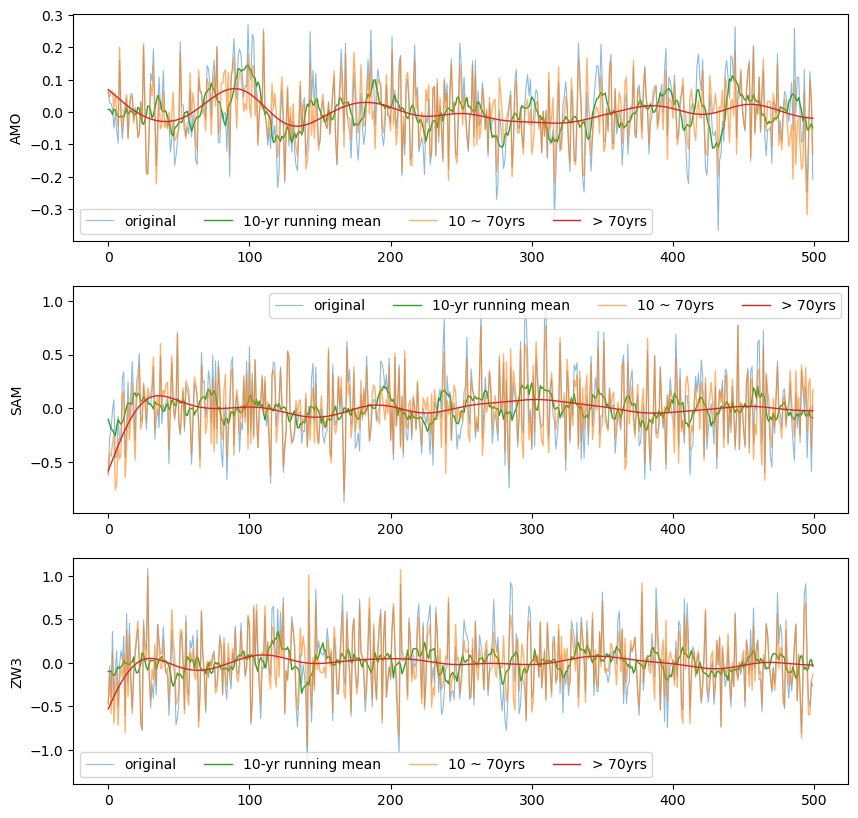

In [96]:
plt.figure(figsize=(10,10))

ax1 = plt.subplot(3,1,1)

subplot_filter(AMO, ax1, 'AMO')

ax2 = plt.subplot(3,1,2)
subplot_filter(SAM, ax2, 'SAM')

ax3 = plt.subplot(3,1,3)
subplot_filter(ZW3, ax3, 'ZW3')

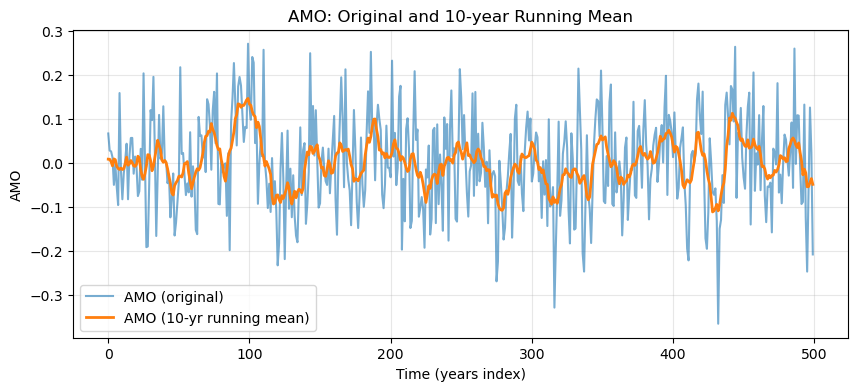

In [70]:
# 10-year running mean of AMO and plot original vs smoothed
window = 10
kernel = np.ones(window) / window
AMO_rm10 = np.convolve(AMO, kernel, mode='same')

plt.figure(figsize=(10,4))
plt.plot(AMO, label='AMO (original)', alpha=0.6)
plt.plot(AMO_rm10, label='AMO (10-yr running mean)', linewidth=2, color='C1')
plt.title('AMO: Original and 10-year Running Mean')
plt.legend()
plt.ylabel('AMO')
plt.xlabel('Time (years index)')
plt.grid(alpha=0.3)

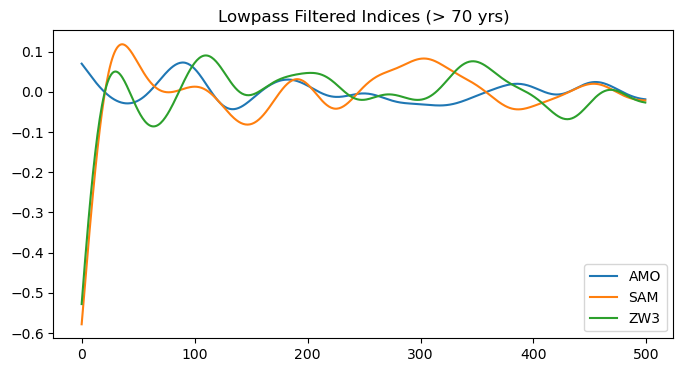

In [66]:
plt.figure(figsize=(8,4))
plt.plot(butterfilter(AMO, 1/70, btype='lowpass'), label='AMO')
plt.plot(butterfilter(SAM, 1/70, btype='lowpass'), label='SAM')
plt.plot(butterfilter(ZW3, 1/70, btype='lowpass'), label='ZW3')
plt.title('Lowpass Filtered Indices (> 70 yrs)')
plt.legend()

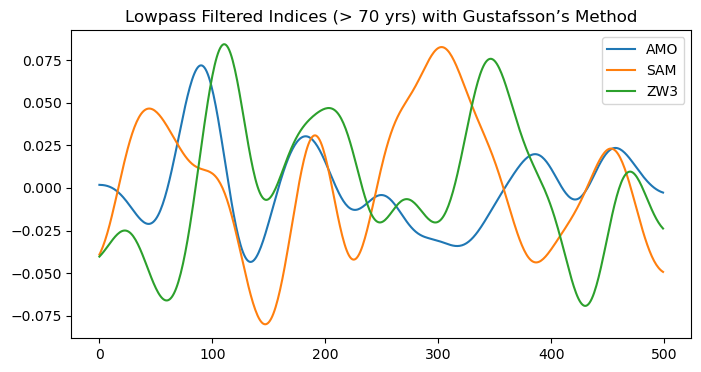

In [68]:
plt.figure(figsize=(8,4))
plt.plot(butterfilter_gust(AMO, 1/70, btype='lowpass'), label='AMO')
plt.plot(butterfilter_gust(SAM, 1/70, btype='lowpass'), label='SAM')
plt.plot(butterfilter_gust(ZW3, 1/70, btype='lowpass'), label='ZW3')
plt.title('Lowpass Filtered Indices (> 70 yrs) with Gustafsson’s Method')
plt.legend()

Text(0, 0.5, 'drake passage')

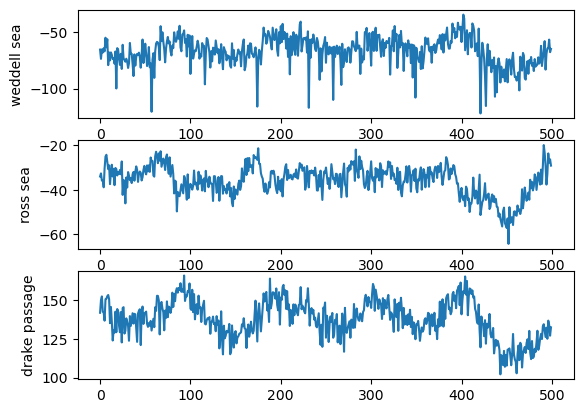

In [131]:
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(Psi_gyres_sep.ws)
plt.ylabel('weddell sea')
plt.subplot(3, 1, 2)
plt.plot(Psi_gyres_sep.rs)
plt.ylabel('ross sea')
plt.subplot(3, 1, 3)
plt.plot(ACC_drake_69)
plt.ylabel('drake passage')

Text(0, 0.5, 'drake passage')

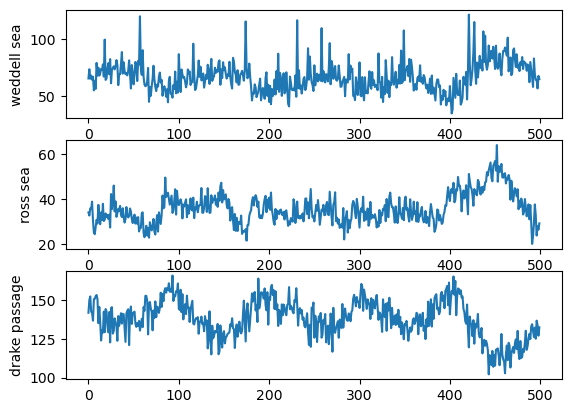

In [211]:
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(-Psi_gyres_sep.ws)
plt.ylabel('weddell sea')
plt.subplot(3, 1, 2)
plt.plot(-Psi_gyres_sep.rs)
plt.ylabel('ross sea')
plt.subplot(3, 1, 3)
plt.plot(ACC_drake_69)
plt.ylabel('drake passage')

In [39]:
gyre_ws_min = gyre_ws.where(gyre_ws <=gyre_ws.min(), drop=True)

In [74]:
gyre_rs_min = gyre_rs.where(gyre_rs <=gyre_rs.min(), drop=True)

In [51]:
gyre_ws.lat.min()

<xarray.DataArray 'lat' ()> Size: 8B
array(-78.77507019)

In [242]:
def lag_cor(x,y,lag, c, l):
    stat=[]
    x = x
    y = y
    from scipy import stats
    for i in range(2*lag):
        slope, intercept, r_value, p_value, std_err = stats.linregress(x[lag:len(x)-lag], y[i:len(y)-2*lag+i])
        stat.append(r_value)
    x=np.linspace(-lag,lag+1, 2*lag)
    plt.grid(True,which="both",ls="-", color='0.65')
    plt.plot(x, stat, c, label=l, linewidth=3.0)
    plt.xlabel('Year lag')
    plt.ylabel('r')

In [ ]:
# Low-Pass Filter
def lowpass(data, cutoff: float, sample_rate: float, poles: int = 4):
    sos = signal.butter(poles, cutoff, 'lowpass', fs=sample_rate, output='sos')
    filtered_data = signal.sosfiltfilt(sos, data)
    return filtered_data

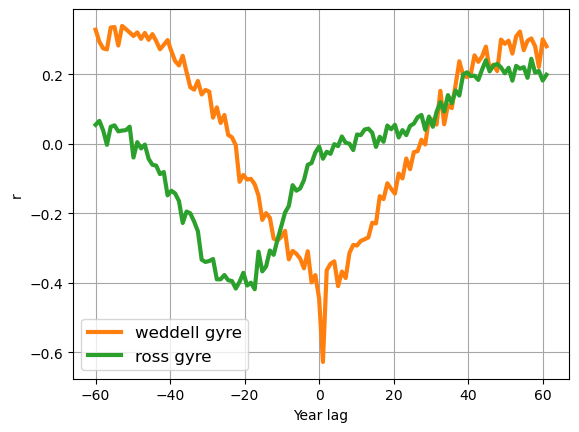

In [212]:
lag_time = 60

fig = plt.figure()
lag_cor(ACC_drake_69, -Psi_gyres_sep.ws, lag_time, 'C1' ,'weddell gyre')
lag_cor(ACC_drake_69, -Psi_gyres_sep.rs, lag_time, 'C2' ,'ross gyre')

# lag_cor(Psi_gyres_sep.ws, curl_sep_ws_n_mean - curl_sep_ws_c_mean, 60, 'C4' ,'south - center')
# lag_cor(Psi_gyres_sep.ws, curl_sep_ws_s_mean - curl_sep_ws_c_mean, 60, 'C5' ,'south - center')
# plt.xlabel('Years lag', fontsize=18)
# plt.ylabel('Correlation coefficient', fontsize=18)
# plt.xticks(fontsize = 15)
# plt.yticks(fontsize = 15)
plt.legend(fontsize = 12)

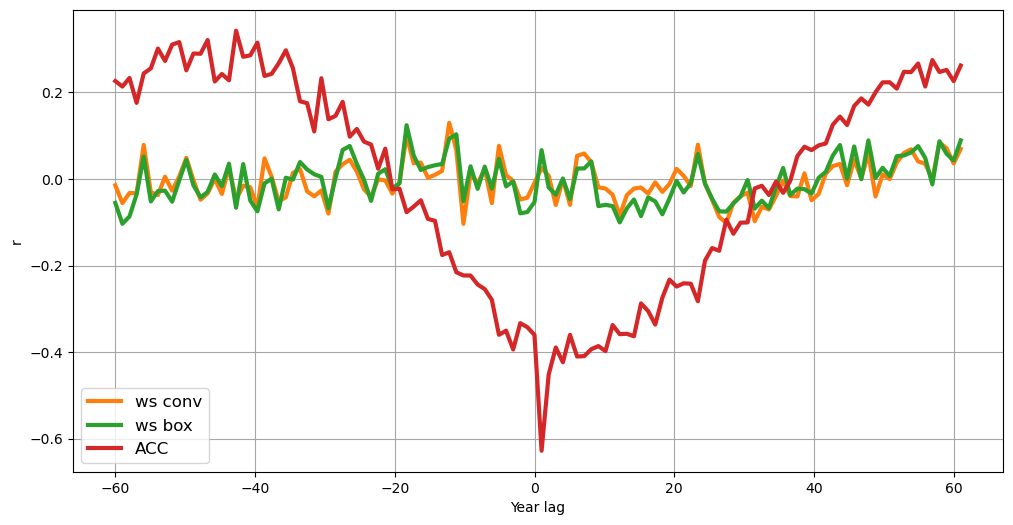

In [210]:
lag_time = 40

fig = plt.figure(figsize = (12,6))
lag_cor(-Psi_gyres_sep.ws, curl_sep_ws_region, 60, 'C1' ,'ws conv')
lag_cor(-Psi_gyres_sep.ws, curl_sep_ws_box_region, 60, 'C2' ,'ws box')
lag_cor(-Psi_gyres_sep.ws, ACC_drake_69, 60, 'C3' ,'ACC')

# lag_cor(Psi_gyres_sep.ws, curl_sep_ws_n_mean - curl_sep_ws_c_mean, 60, 'C4' ,'south - center')
# lag_cor(Psi_gyres_sep.ws, curl_sep_ws_s_mean - curl_sep_ws_c_mean, 60, 'C5' ,'south - center')
# plt.xlabel('Years lag', fontsize=18)
# plt.ylabel('Correlation coefficient', fontsize=18)
# plt.xticks(fontsize = 15)
# plt.yticks(fontsize = 15)
plt.legend(fontsize = 12)
# plt.title('Lagged correlation (Ross Sea Convection index), year {}-{}, {}'.format(start_year, end_year, model_name), fontsize=18)

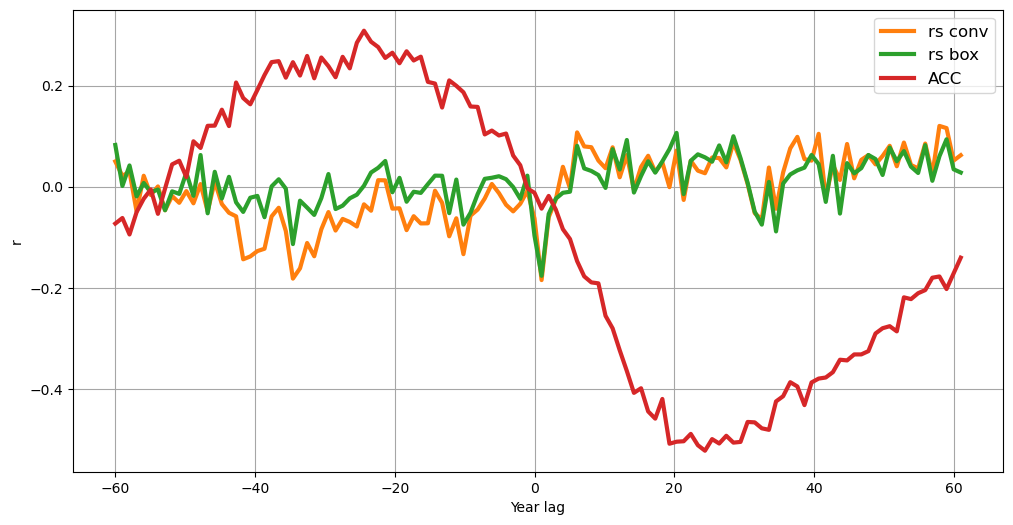

In [213]:
lag_time = 60

fig = plt.figure(figsize = (12,6))
lag_cor(-Psi_gyres_sep.rs, curl_sep_rs_region, lag_time, 'C1' ,'rs conv')
lag_cor(-Psi_gyres_sep.rs, curl_sep_rs_box_region, lag_time, 'C2' ,'rs box')
lag_cor(-Psi_gyres_sep.rs, ACC_drake_69, lag_time, 'C3' ,'ACC')

# lag_cor(Psi_gyres_sep.ws, curl_sep_ws_n_mean - curl_sep_ws_c_mean, 60, 'C4' ,'south - center')
# lag_cor(Psi_gyres_sep.ws, curl_sep_ws_s_mean - curl_sep_ws_c_mean, 60, 'C5' ,'south - center')
# plt.xlabel('Years lag', fontsize=18)
# plt.ylabel('Correlation coefficient', fontsize=18)
# plt.xticks(fontsize = 15)
# plt.yticks(fontsize = 15)
plt.legend(fontsize = 12)

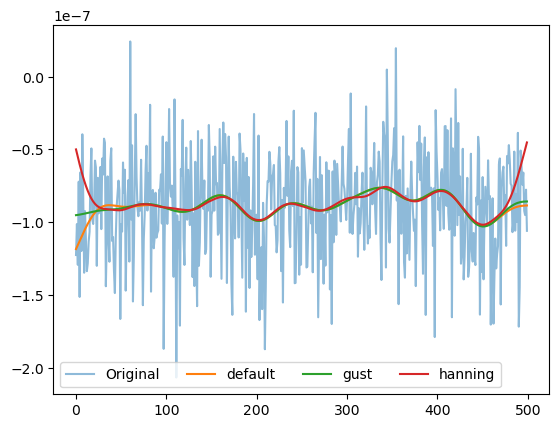

In [247]:
plt.plot(curl_sep_ws_box_region, label='Original', alpha = 0.5)

b, a = signal.butter(4, 2/140, fs=1)
plt.plot(signal.filtfilt(b, a, curl_sep_ws_box_region), label = 'default')
plt.plot(signal.filtfilt(b, a, curl_sep_ws_box_region, method="gust"), label = 'gust')

kernel = np.hanning(70)
# normalize the kernel
kernel = kernel / kernel.sum()
# Create a filtered signal by convolving the kernel with the original data
plt.plot(np.convolve(kernel, curl_sep_ws_box_region, mode='same'), label='hanning')


plt.legend(ncol = 4)

Text(0, 0.5, 'drake passage')

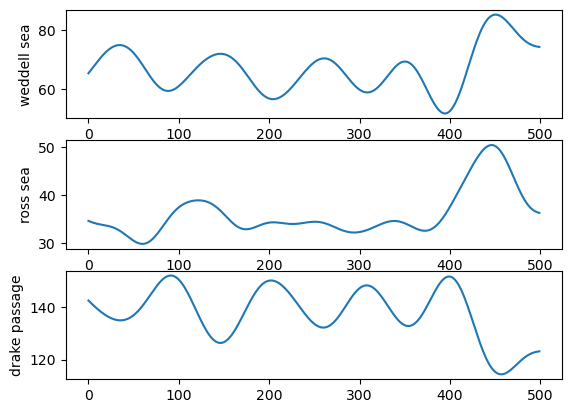

In [248]:
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(lowpass_70(-Psi_gyres_sep.ws))
plt.ylabel('weddell sea')
plt.subplot(3, 1, 2)
plt.plot(lowpass_70(-Psi_gyres_sep.rs))
plt.ylabel('ross sea')
plt.subplot(3, 1, 3)
plt.plot(lowpass_70(ACC_drake_69))
plt.ylabel('drake passage')

In [245]:
def lowpass_70(data):
    return lowpass(data, cutoff=2/140, sample_rate=1, poles=4)

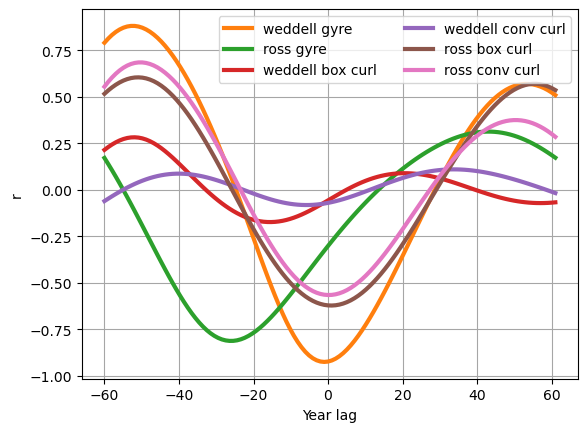

In [246]:
lag_time = 60

fig = plt.figure()
lag_cor(lowpass_70(ACC_drake_69), lowpass_70(-Psi_gyres_sep.ws), lag_time, 'C1' ,'weddell gyre')
lag_cor(lowpass_70(ACC_drake_69), lowpass_70(-Psi_gyres_sep.rs), lag_time, 'C2' ,'ross gyre')

lag_cor(lowpass_70(ACC_drake_69), lowpass_70(curl_sep_ws_box_region), lag_time, 'C3' ,'weddell box curl')
lag_cor(lowpass_70(ACC_drake_69), lowpass_70(curl_sep_ws_region), lag_time, 'C4' ,'weddell conv curl')

lag_cor(lowpass_70(ACC_drake_69), lowpass_70(curl_sep_rs_box_region), lag_time, 'C5' ,'ross box curl')
lag_cor(lowpass_70(ACC_drake_69), lowpass_70(curl_sep_rs_region), lag_time, 'C6' ,'ross conv curl')

plt.legend(ncol = 2)

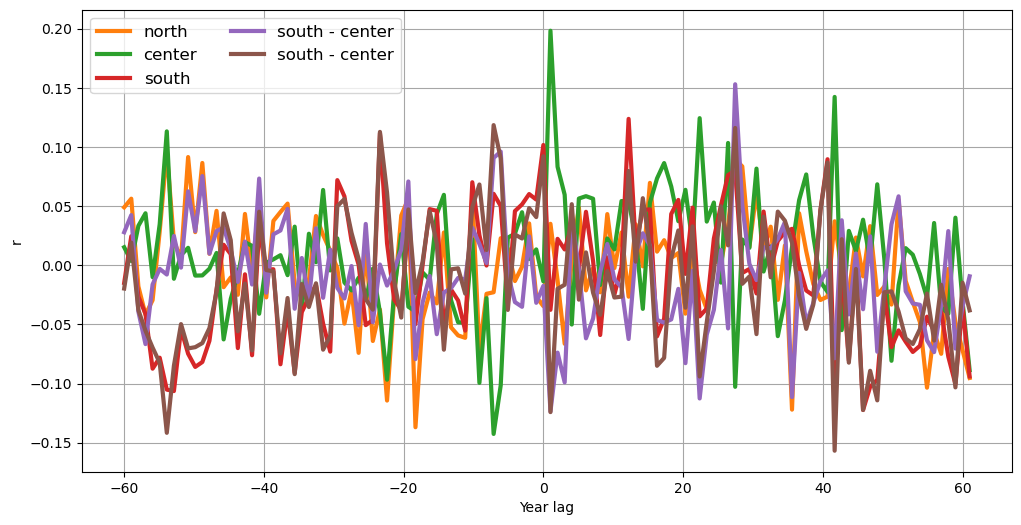

In [88]:
lag_time = 40

fig = plt.figure(figsize = (12,6))
lag_cor(Psi_gyres_sep.ws, curl_sep_ws_n_mean, 60, 'C1' ,'north')
lag_cor(Psi_gyres_sep.ws, curl_sep_ws_c_mean, 60, 'C2' ,'center')
lag_cor(Psi_gyres_sep.ws, curl_sep_ws_s_mean, 60, 'C3' ,'south')


lag_cor(Psi_gyres_sep.ws, curl_sep_ws_n_mean - curl_sep_ws_c_mean, 60, 'C4' ,'south - center')
lag_cor(Psi_gyres_sep.ws, curl_sep_ws_s_mean - curl_sep_ws_c_mean, 60, 'C5' ,'south - center')
# plt.xlabel('Years lag', fontsize=18)
# plt.ylabel('Correlation coefficient', fontsize=18)
# plt.xticks(fontsize = 15)
# plt.yticks(fontsize = 15)
plt.legend(fontsize = 12, ncol=2)
# plt.title('Lagged correlation (Ross Sea Convection index), year {}-{}, {}'.format(start_year, end_year, model_name), fontsize=18)

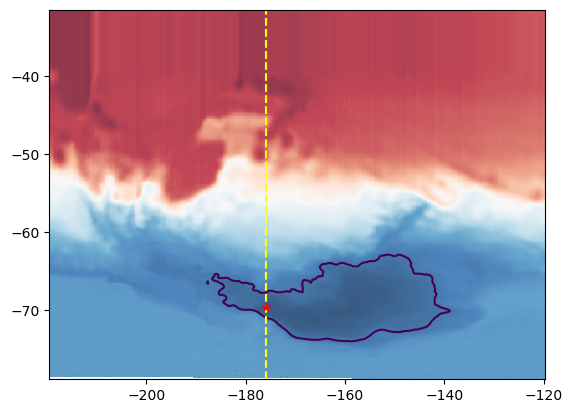

In [75]:
plt.pcolormesh(gyre_rs.lon, gyre_rs.lat, gyre_rs, alpha= 0.8, cmap=plt.cm.RdBu_r)
plt.contour(gyre_rs.lon, gyre_rs.lat, gyre_rs, levels = [-18])

plt.plot([gyre_rs_min.lon.item(), gyre_rs_min.lon.item()], [gyre_rs.lat.min().item(), gyre_rs.lat.max().item()], ls = '--', color = "yellow")

plt.scatter(gyre_rs_min.lon,gyre_rs_min.lat, marker='*', color='r', s=25, zorder = 10)

In [3]:
ds_pr = ReadDataFromNCAR(variable_id = 'pr', table_id = 'Amon')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [8]:
ds_evs = ReadDataFromNCAR(variable_id = 'evs', table_id = 'Omon')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [12]:
ds_wfo = open_from_cloud("gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piControl/r1i1p1f1/Omon/wfo/gn/v20180701")

In [19]:
grid_out = grid_out = xr.Dataset({"x": (["x"], ds_wfo.x.values), "y": (["y"], ds_wfo.y.values)})
grid_pr = xr.Dataset({"lon": (["lon"], ds_pr.lon.values), "lat": (["lat"], ds_pr.lat.values)})
grid_evs = xr.Dataset({"lon": (["lon"], ds_evs.lon.values), "lat": (["lat"], ds_evs.lat.values)})

In [22]:
select_month(ds_evs.evs, 9)

<xarray.DataArray 'evs' (time: 500, lat: 180, lon: 360)> Size: 130MB
dask.array<getitem, shape=(500, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time     (time) object 4kB 0151-09-16 00:00:00 ... 0650-09-16 00:00:00
Attributes:
    long_name:      Water Evaporation Flux Where Ice Free Ocean over Sea
    units:          kg m-2 s-1
    cell_methods:   area: mean where ice_free_sea over sea time: mean
    cell_measures:  area: areacello
    standard_name:  water_evapotranspiration_flux
    interp_method:  conserve_order1
    original_name:  evs
    comment:        Model data on the 1x1 grid includes values in all cells f...

In [26]:
ds_wfo.wfo.where(openpickle("conv_rs", "data/")>0)

<xarray.DataArray 'wfo' (time: 6000, y: 329, x: 300)> Size: 2GB
dask.array<where, shape=(6000, 329, 300), dtype=float32, chunksize=(15, 329, 300), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 48kB 0151-01-16 12:00:00 ... 0650-12-16 12:00:00
  * x        (x) float64 2kB -209.9 -209.7 -209.5 ... -135.7 -135.4 -135.2
  * y        (y) float64 3kB -80.39 -80.31 -80.23 ... -40.41 -40.22 -40.03
    lat      (y, x) float32 395kB -80.4 -80.4 -80.41 ... -40.03 -40.03 -40.03
    lon      (y, x) float32 395kB -210.0 -209.7 -209.5 ... -135.1 -134.9 -134.6
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    long_name:      Water Flux into Sea Water
    original_name:  wfo
    standard_name:  water_flux_into_sea_water
    units:          kg m-2 s-1

In [5]:
import intake
cat = intake.open_esm_datastore('/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.json')

In [6]:
ds_pr = ReadDataFromNCAR(variable_id = 'pr', table_id = 'Amon')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [7]:
ds_pr

<xarray.Dataset> Size: 1GB
Dimensions:    (time: 6000, lat: 180, lon: 288, bnds: 2)
Coordinates:
  * bnds       (bnds) float64 16B 1.0 2.0
  * lat        (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 3kB dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon        (lon) float64 2kB 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
    lon_bnds   (lon, bnds) float64 5kB dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 48kB 0151-01-16 12:00:00 ... 0650-12-16 12:00:00
    time_bnds  (time, bnds) object 96kB dask.array<chunksize=(1, 2), meta=np.ndarray>
Data variables:
    pr         (time, lat, lon) float32 1GB dask.array<chunksize=(1, 180, 288), meta=np.ndarray>
Attributes: (12/56)
    external_variables:               areacella
    table_id:                         Amon
    history:                          File was processed by fremetar (GFDL an...
    contact:                          gfdl.climate.model.info@noaa.gov
    comment:                          <null ref>
    further_info_url:                 https://furtherinfo.es-doc.org/CMIP6.NO...
    ...                               ...
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:variable_id:     pr
    intake_esm_attrs:grid_label:      gr1
    intake_esm_attrs:version:         v20180701
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           CMIP.NOAA-GFDL.GFDL-CM4.piControl.Amon.gr1

In [8]:
ds_tgrid = xr.open_dataset("data/ocean_static_0p25_tracer.nc")

In [9]:
xr.open_dataset("data/ocean_hgrid.nc")

<xarray.Dataset> Size: 299MB
Dimensions:   (nyp: 2161, nxp: 2881, ny: 2160, nx: 2880)
Dimensions without coordinates: nyp, nxp, ny, nx
Data variables:
    angle_dx  (nyp, nxp) float64 50MB ...
    area      (ny, nx) float64 50MB ...
    dx        (nyp, nx) float64 50MB ...
    dy        (ny, nxp) float64 50MB ...
    tile      |S255 255B ...
    x         (nyp, nxp) float64 50MB ...
    y         (nyp, nxp) float64 50MB ...

In [9]:
from xgcm import Grid

In [ ]:
ds_st = ReadDataFromNCAR(variable_id = ['so','thetao'], grid_label = 'gn', table_id="Omon")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [4]:
ReadDataFromNCAR(variable_id = ['so'], grid_label = 'gn', table_id="Omon")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


<xarray.Dataset> Size: 1TB
Dimensions:    (time: 6000, lev: 35, y: 1080, x: 1440, bnds: 2, vertex: 4)
Coordinates:
  * bnds       (bnds) float64 16B 1.0 2.0
  * time       (time) object 48kB 0151-01-16 12:00:00 ... 0650-12-16 12:00:00
    time_bnds  (time, bnds) object 96kB dask.array<chunksize=(1, 2), meta=np.ndarray>
  * x          (x) float64 12kB -299.7 -299.5 -299.2 ... 59.53 59.78 60.03
  * y          (y) float64 9kB -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * lev        (lev) float64 280B 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
    lev_bnds   (lev, bnds) float64 560B dask.array<chunksize=(35, 2), meta=np.ndarray>
    lon        (y, x) float32 6MB dask.array<chunksize=(540, 720), meta=np.ndarray>
    lat        (y, x) float32 6MB dask.array<chunksize=(540, 720), meta=np.ndarray>
    lat_bnds   (y, x, vertex) float32 25MB dask.array<chunksize=(540, 720, 1), meta=np.ndarray>
    lon_bnds   (y, x, vertex) float32 25MB dask.array<chunksize=(540, 720, 1), meta=np.ndarray>
Dimensions without coordinates: vertex
Data variables:
    so         (time, lev, y, x) float32 1TB dask.array<chunksize=(1, 7, 270, 360), meta=np.ndarray>
Attributes: (12/56)
    title:                            NOAA GFDL GFDL-CM4 model output prepare...
    external_variables:               areacello volcello
    history:                          File was processed by fremetar (GFDL an...
    table_id:                         Omon
    activity_id:                      CMIP
    branch_method:                    standard
    ...                               ...
    intake_esm_attrs:table_id:        Omon
    intake_esm_attrs:variable_id:     so
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         v20180701
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           CMIP.NOAA-GFDL.GFDL-CM4.piControl.Omon.gn

In [3]:
ds_v = ReadDataFromNCAR(variable_id = ['uo','vo'], grid_label = 'gn', table_id="Omon")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [4]:
ds_fx = ReadDataFromNCAR(variable_id=["basin", "areacello"], grid_label = 'gn')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [20]:
ds_vgrid = xr.open_dataset("data/ocean_static_0p25_vgrid.nc")
ds_ugrid = xr.open_dataset("data/ocean_static_0p25_ugrid.nc")

In [45]:
def replace_uvgrid(da, dsgrid, dimname, renamedim, latname = 'lat', lonname = 'lon', renamelat = 'lat_r', renamelon = 'lon_r'):
    da[dimname] = dsgrid[dimname]
    da[latname] = dsgrid[latname]
    da[lonname] = dsgrid[lonname]
    da = da.rename({dimname: renamedim, latname: renamelat, lonname: renamelon})
    return da

In [50]:
dav = replace_uvgrid(ds_v.vo, ds_vgrid, 'y', 'y_r', renamelat = 'lat_v', renamelon = 'lon_v') 
dau = replace_uvgrid(ds_v.uo, ds_ugrid, 'x', 'x_r', renamelat = 'lat_u', renamelon = 'lon_u') 

In [52]:
ds_all = xr.Dataset({'so': ds_st.so, 'thetao': ds_st.thetao, 'vo': dav, 'uo': dau})

In [55]:
grid = Grid(ds_all, coords={'X': {'center': 'x', 'right': 'x_r'},
                        'Y': {'center': 'y', 'right': 'y_r'}}, periodic=['X'])

In [91]:
def calculate_advection(da, grid, ax, dav, dx):
    flux = grid.interp(da, axis=ax, to="right") * dav
    adv = grid.diff(flux, axis = ax) / dx
    return adv

In [73]:
def calc_dx(lon, lat):
    ''' This definition calculates the distance 
        between grid points that are in
        a latitude/longitude format.
        
        Using pyproj GEOD; different Earth Shapes 
        https://jswhit.github.io/pyproj/pyproj.Geod-class.html
        Common shapes: 'sphere', 'WGS84', 'GRS80'
        
        Accepts, 1D arrays for latitude and longitude
        
        Returns: dx, dy; 2D arrays of distances 
                       between grid points in the x and y direction in meters
        ------------
        modified from:
        https://github.com/Unidata/MetPy/issues/288#issuecomment-279481555
    '''
    from pyproj import Geod
    
    g = Geod(ellps='sphere')
    
    lon = lon.values
    lat = lat.values
    
    dx = np.empty(lon.shape)
    dy = np.zeros(lat.shape)
    
    for i in range(dx.shape[0]-1):
        for j in range(dx.shape[1]):
            _, _, dy[i,j] = g.inv(lon[i,j], lat[i,j], lon[i+1,j], lat[i+1,j])
    dy[i+1,:] = dy[i,:]
            
    for i in range(dx.shape[0]):
        for j in range(dy.shape[1]):
            if j < dy.shape[1]-1:
                _, _, dx[i,j] = g.inv(lon[i,j], lat[i,j], lon[i,j+1], lat[i,j+1])
            else:            
                _, _, dx[i,j] = g.inv(lon[i,j], lat[i,j], lon[i,0], lat[i,0])
    
    return dx, dy

In [74]:
dxv, dyv = calc_dx(ds_vgrid.lon, ds_vgrid.lat)

In [92]:
adv_salt_v = calculate_advection(ds_all.so, grid, "Y", dav, dyv)

In [61]:
flux_so_v = grid.interp(ds_all.so, axis="Y", to="right") * dav
flux_so_u = grid.interp(ds_all.so, axis="X", to="right") * dau

flux_thetao_v = grid.interp(ds_all.thetao, axis="Y", to="right") * dav
flux_thetao_u = grid.interp(ds_all.thetao, axis="X", to="right") * dau